#Recognition of the earth's surface
Here we will create and train a convolutional neural network to recognize the types of the earth's surface from satellite images. We will use the EuroSat Dataset open dataset from the Kaggle platform (https://www.kaggle.com/datasets/apollo2506/eurosat-dataset).

#Распознование поверхности земли
Здесь мы создадим и обучим сверточную нейронную сеть для распознавания типов поверхности земли, по снимкам со спутников. Мы будем использовать открытый датасет EuroSat Dataset с платформы Kaggle (https://www.kaggle.com/datasets/apollo2506/eurosat-dataset).

#Downloading and preparing data

#Скачивание и подготовка данных

Importing the necessary libraries, specifically:
1. kagglehub - for downloading dataset from Kaggle
2. os - for working with files and directories
3. PIL - to open images
4. pandas - for working with csv files
5. torch - for working with PyTorch
6. Dataset, DataLoader - abstract classes for working with datasets
7. torchvision.transforms - for image processing
8. pyplot - for plotting graphs

Импортируем нужные библиотеки, а конкретно:
1. kagglehub - для скачивания датасета с Kaggle
2. os - для работы с файлами и дерикториями
3. PIL - для открытия изображений
4. pandas - для работы с csv файлами
5. torch - для работы с PyTorch
6. Dataset, DataLoader - абстрактные классы для работы с датасетами
7. torchvision.transforms - для обработки изображений
8. pyplot - для построения графиков

In [116]:
import kagglehub
import os
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

Reading the path to the dataset and downloading it

Считываем путь к датасету и скачиваем его

In [13]:
DATASET_LINK = "apollo2506/eurosat-dataset"
dataset_path = kagglehub.dataset_download(DATASET_LINK)
dataset_jpg_path = os.path.join(dataset_path, "EuroSAT")

For example, by reading the first picture from the Highway class folder to make sure that everything was read correctly.

Считаем для примера первую картинку из папки класса 'Highway', что бы убедится, что все считалось правильно

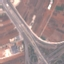

In [36]:
class_path = (os.path.join(dataset_jpg_path, 'Highway'))
file_name = os.listdir(class_path)[0]
img_path = os.path.join(class_path, file_name)

img = Image.open(img_path)
img

Reading csv files that split the dataset into training, validation, and test samples (train.csv, test.csv, validation.csv). Checking for missing values, data types.


Считываем csv файлы, которые разбивают датасет на обучающую, валидационную и тестовую выборку (train.csv, test.csv, validation.csv). Проверим наличие пропущенных значений, типы данных.

In [47]:
train_df = pd.read_csv(os.path.join(dataset_jpg_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(dataset_jpg_path, 'test.csv'))
validation_df = pd.read_csv(os.path.join(dataset_jpg_path, 'validation.csv'))

In [64]:
print('data types:')
print(train_df.dtypes)
print("==============")
print('nulls:')
print(train_df.isnull().sum())
train_df.head()

data types:
Unnamed: 0     int64
Filename      object
Label          int64
ClassName     object
dtype: object
nulls:
Unnamed: 0    0
Filename      0
Label         0
ClassName     0
dtype: int64


,Unnamed: 0,Filename,Label,ClassName
0,16257,AnnualCrop/AnnualCrop_142.jpg,0,AnnualCrop
1,3297,HerbaceousVegetation/HerbaceousVegetation_2835...,2,HerbaceousVegetation
2,17881,PermanentCrop/PermanentCrop_1073.jpg,6,PermanentCrop
3,2223,Industrial/Industrial_453.jpg,4,Industrial
4,4887,HerbaceousVegetation/HerbaceousVegetation_1810...,2,HerbaceousVegetation


In [65]:
print('data types:')
print(test_df.dtypes)
print("==============")
print('nulls:')
print(test_df.isnull().sum())
test_df.head()

data types:
Unnamed: 0     int64
Filename      object
Label          int64
ClassName     object
dtype: object
nulls:
Unnamed: 0    0
Filename      0
Label         0
ClassName     0
dtype: int64


,Unnamed: 0,Filename,Label,ClassName
0,2438,AnnualCrop/AnnualCrop_1275.jpg,0,AnnualCrop
1,1018,Residential/Residential_504.jpg,7,Residential
2,3,Pasture/Pasture_787.jpg,5,Pasture
3,1011,Residential/Residential_1575.jpg,7,Residential
4,47,Pasture/Pasture_473.jpg,5,Pasture


In [66]:
print('data types:')
print(validation_df.dtypes)
print("==============")
print('nulls:')
print(validation_df.isnull().sum())
validation_df.head()

data types:
Unnamed: 0     int64
Filename      object
Label          int64
ClassName     object
dtype: object
nulls:
Unnamed: 0    0
Filename      0
Label         0
ClassName     0
dtype: int64


,Unnamed: 0,Filename,Label,ClassName
0,258,Pasture/Pasture_1481.jpg,5,Pasture
1,2134,Forest/Forest_2638.jpg,1,Forest
2,3518,Highway/Highway_875.jpg,3,Highway
3,3048,River/River_434.jpg,8,River
4,3996,SeaLake/SeaLake_2930.jpg,9,SeaLake


Now creating a class for creating a dataset

Тепер создадим класс для создания датасета

In [69]:
class EuroSATDataset(Dataset):
    # Initialize the Dataset class:
    # Инициализируем класс Dataset:
    def __init__(self, dataframe, root_dir, transform=None):

        self.dataframe = dataframe # dataframe is a DataFrame with information about paths to images and labels | dataframe — это DataFrame с информацией о путях к изображениям и метках.
        self.root_dir = root_dir # root_dir is the root directory where the images are located | root_dir — это корневая директория, где находятся изображения
        self.transform = transform # transform — these are transformations that will be applied to images (resize) | transform — это преобразования, которые будут применяться к изображениям (resize)

    def __len__(self):

        return len(self.dataframe) # We return the number of examples in the dataset (rows in the dataframe) | Возвращаем количество примеров в датасете (строк в dataframe).

    def __getitem__(self, idx):

        img_name = self.dataframe.iloc[idx, 1]  # image path (first column) | путь к изображению (первая колонка)
        label = self.dataframe.iloc[idx, 2] # class label (second column) | метка класса (вторая колонка)

        img_path = os.path.join(self.root_dir, img_name) # Building the full path to the image | Строим полный путь к изображению

        image = Image.open(img_path) # Opening the image | Открываем изображение

        # If transformations are set, we apply them to the image.
        # Если трансформации заданы, применяем их к изображению.
        if self.transform:
            image = self.transform(image)


        return image, label # Returning the tuple (image, label) | Возвращаем кортеж (изображение, метка)


Creating a transform to convert an image to a 64x64 size, as well as using the ToTensor function, which converts an image into a tensor
with a dimension of (3, 64, 64) — 3 channels (RGB) and an image size of 64x64 pixels.

Создадим transform для преобразования изображения в размер 64x64, а также применим функцию ToTensor, которая преобразует изображение в тензор
с размерностью (3, 64, 64) — 3 канала (RGB) и размер изображения 64x64 пикселей.

In [70]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Creating datasets and DataLoaders

Создаём датасеты и DataLoader'ы

In [71]:
train_dataset = EuroSATDataset(train_df, dataset_jpg_path, transform=transform)
test_dataset = EuroSATDataset(test_df, dataset_jpg_path, transform=transform)
val_dataset = EuroSATDataset(validation_df, dataset_jpg_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Creating a list of classes, ordered by class number:
1. The Label and ClassName columns are taken
2. Duplicates are removed (only 10 class entries remain)
3. Sorted by class number.
4. Use unique() to get the list.


Создадим список классов, упарядоченный по номеру класса:
1. Берем столбцы Label и ClassName
2. Убираем дубликаты (остаются только 10 записей с классами)
3. Сортируем по номеру класса.
4. Используем unique(), что бы получить список

In [99]:
class_names = train_df[['Label', 'ClassName']]\
              .drop_duplicates()\
              .sort_values('Label')\
              .ClassName.unique()

In [104]:
class_names

array(['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
       'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River',
       'SeaLake'], dtype=object)

Output for example random 9 images from the training sample with their class labels

Выведем для примера случайные 9 изображений из обучающей выборки с их метками классов

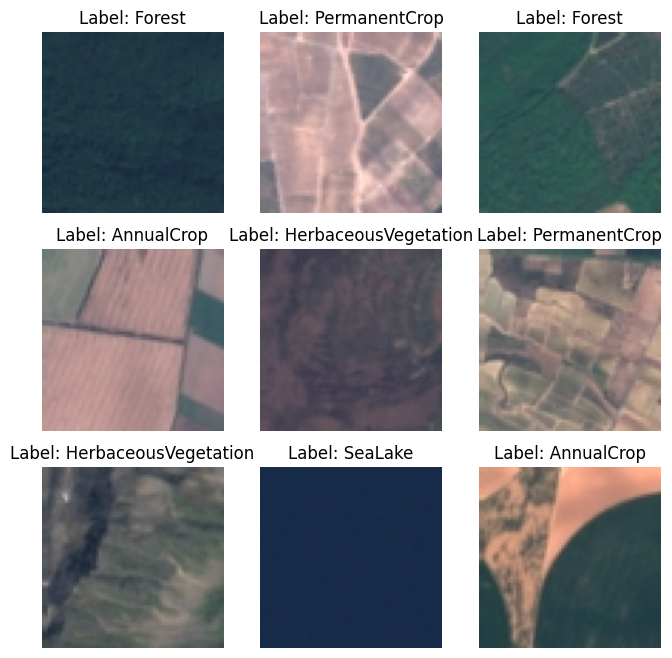

In [111]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].permute(1, 2, 0))  # из (C, H, W) в (H, W, C)
    plt.title(f"Label: {class_names[labels[i]]}")
    plt.axis('off')
plt.show()


Датасеты готовы!

#Configuring neural network layers, training parameters, and neural network training

#Настройка слоев нейросети, параметров обучения и обучение нейросети

Configuring neural network layers

Настройка слоев

In [114]:
class EuroSATModel(nn.Module):
    def __init__(self):
        super(EuroSATModel, self).__init__()

        # The first convolutional layer (16 filters, 3x3 core, padding 1, maxpowling 2x2)
        # Первый сверточный слой (16 фильтров, ядро 3x3, padding 1, макспулинг 2x2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional layer (32 filters, 3x3 core, padding 1, maxpowling 2x2)
        # Второй сверточный слой (32 фильтра, ядро 3x3, padding 1, макспулинг 2x2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # The third convolutional layer (64 filters, 3x3 core, padding 1, maxpowling 2x2)
        # Третий сверточный слой (64 фильтра, ядро 3x3, padding 1, макспулинг 2x2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers after convolutional (flattening)
        # Полносвязные слои после сверточных (flattening)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # The size of the 64 filter is 8x8 after all pooling (if the input image is 64x64) | Размер 64 фильтра, 8x8 после всех пулингов (если входное изображение 64x64)
        self.fc2 = nn.Linear(256, 10)  # 10 classes | 10 классов

    def forward(self, x):
        # We go through the first convolutional layer and pooling
        # Проходим через первый сверточный слой и пулинг
        x = self.pool1(torch.relu(self.conv1(x)))

        # We go through the second convolutional layer and pooling
        # Проходим через второй сверточный слой и пулинг
        x = self.pool2(torch.relu(self.conv2(x)))

        # We go through the third convolutional layer and pooling
        # Проходим через третий сверточный слой и пулинг
        x = self.pool3(torch.relu(self.conv3(x)))

        # Converting the tensor to the form (batch_size, 64 * 8 * 8 )
        # Переводим тензор в форму (batch_size, 64 * 8 * 8)
        x = x.view(-1, 64 * 8 * 8)

        # Fully connected layer
        # Полносвязный слой
        x = torch.relu(self.fc1(x))

        # Output layer (classification)
        # Выходной слой (классификация)
        x = self.fc2(x)

        return x

Creating a function to evaluate the quality of a model based on a validation sample

Создадим функцию для оценки качества модели на валидационной выборке

In [123]:
def evaluate(model, val_loader):
    model.eval()  # Setting the model to evaluation mode | Устанавливаем модель в режим оценки
    correct = 0  # A variable for calculating the number of correct predictions | Переменная для подсчета количества правильных прогнозов
    total = 0  # A variable for counting the total number of samples | Переменная для подсчета общего числа образцов
    val_loss = 0.0  # Variable for calculating validation losses| Переменная для подсчета потерь на валидации
    criterion = nn.CrossEntropyLoss()  # Loss function for multiclass classification | Функция потерь для многоклассовой классификации

    with torch.no_grad():  # Disabling the calculation of gradients to improve performance during evaluation | Отключаем вычисление градиентов для улучшения производительности во время оценки
        for inputs, labels in val_loader:  # Iterate over the validation data loader | Итерируем по валидационному загрузчику данных
            outputs = model(inputs)  # Run the input data through the model to obtain forecasts | Прогоняем входные данные через модель для получения прогнозов

            loss = criterion(outputs, labels)  # Calculate losses (errors) for the current data portion | Вычисляем потери (ошибки) для текущей порции данных
            val_loss += loss.item()  # Add losses to the total amount | Добавляем потери к общей сумме

            # Determining the number of correct forecasts | Определяем количество правильных прогнозов
            _, predicted = torch.max(outputs, 1)  # Choosing the class with the highest probability | Выбираем класс с максимальной вероятностью
            total += labels.size(0)  # Increasing the total number of samples | Увеличиваем общее количество образцов
            correct += (predicted == labels).sum().item()  # Let's summarize the number of correct predictions | Суммируем количество правильных прогнозов

    accuracy = 100 * correct / total  # Calculate the accuracy as the percentage of correct answers | Вычисляем точность как процент правильных ответов
    avg_val_loss = val_loss / len(val_loader)  # Average losses in the validation sample | Средние потери на валидационной выборке

    return accuracy, avg_val_loss  # Return accuracy and average losses | Возвращаем точность и средние потери

Creating a cycle for training a neural network of 10 epochs

Создадим цикл для обучения нейросети из 10 эпох

In [160]:
# Creating a model
# Создаем модель
model = EuroSATModel()

# Defining the loss function (Cross-Entropy Loss)
# Определяем функцию потерь (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Defining an optimizer (for example, Adam)
# Определяем оптимизатор (например, Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Setting the model to training mode | Устанавливаем модель в режим тренировки
    running_loss = 0.0

    # Model training
    # Тренировка модели
    for inputs, labels in train_loader:
        # Zeroing out the gradients of the previous steps
        # Обнуляем градиенты предыдущих шагов
        optimizer.zero_grad()

        # Running through the model
        # Прогоняем через модель
        outputs = model(inputs)

        # Calculating losses
        # Вычисляем потери
        loss = criterion(outputs, labels)

        # Error propagation back
        # Обратное распространение ошибки
        loss.backward()

        # Updating the model parameters
        # Обновляем параметры модели
        optimizer.step()

        # Summarize the losses
        # Суммируем потери
        running_loss += loss.item()

    # Assessment for validation
    # Оценка на валидации
    val_accuracy, val_loss = evaluate(model, val_loader)

    val_accuracy, val_loss = evaluate(model, val_loader)

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Output statistics for each epoch
    # Выводим статистику для каждой эпохи
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, "
          f"Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {val_loss:.4f}")

Epoch 1/10, Loss: 1.2046598205106513, Validation Accuracy: 71.43%, Validation Loss: 0.7873
Epoch 2/10, Loss: 0.7836402269385995, Validation Accuracy: 70.85%, Validation Loss: 0.7651
Epoch 3/10, Loss: 0.6609252114636845, Validation Accuracy: 78.06%, Validation Loss: 0.6111
Epoch 4/10, Loss: 0.5765333073040354, Validation Accuracy: 80.63%, Validation Loss: 0.5604
Epoch 5/10, Loss: 0.5254353103929164, Validation Accuracy: 82.67%, Validation Loss: 0.4982
Epoch 6/10, Loss: 0.45703620800209527, Validation Accuracy: 81.41%, Validation Loss: 0.5220
Epoch 7/10, Loss: 0.4299004916511413, Validation Accuracy: 82.43%, Validation Loss: 0.5103
Epoch 8/10, Loss: 0.36895733179174706, Validation Accuracy: 84.46%, Validation Loss: 0.4600
Epoch 9/10, Loss: 0.33665387486241594, Validation Accuracy: 85.52%, Validation Loss: 0.4354
Epoch 10/10, Loss: 0.2857303199076209, Validation Accuracy: 85.20%, Validation Loss: 0.4313


Building a learning schedule

Построим график обучения

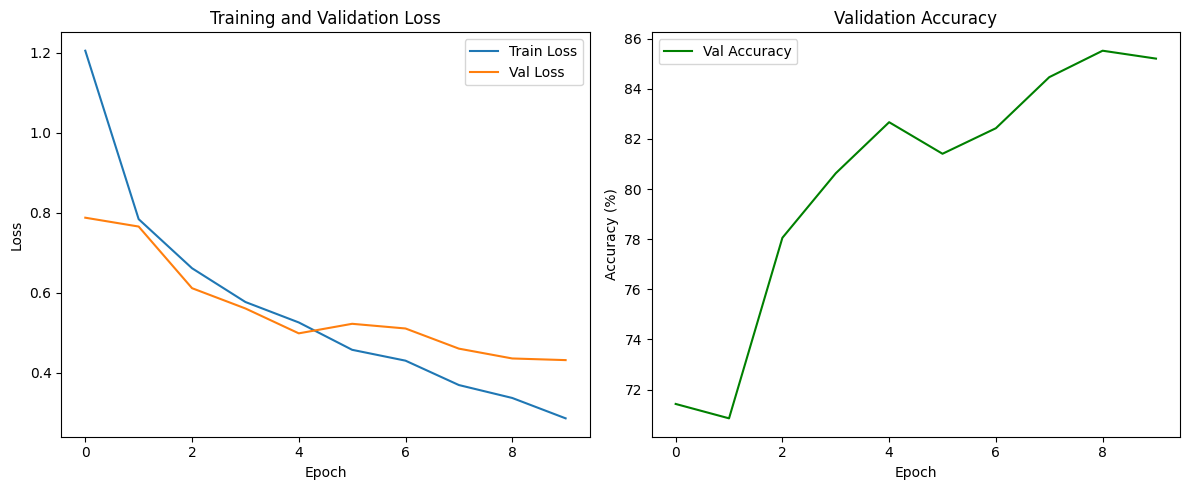

In [162]:
plt.figure(figsize=(12, 5))

# Losses | Потери
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy | Точность
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Building an error matrix

Построим матрицу ошибок

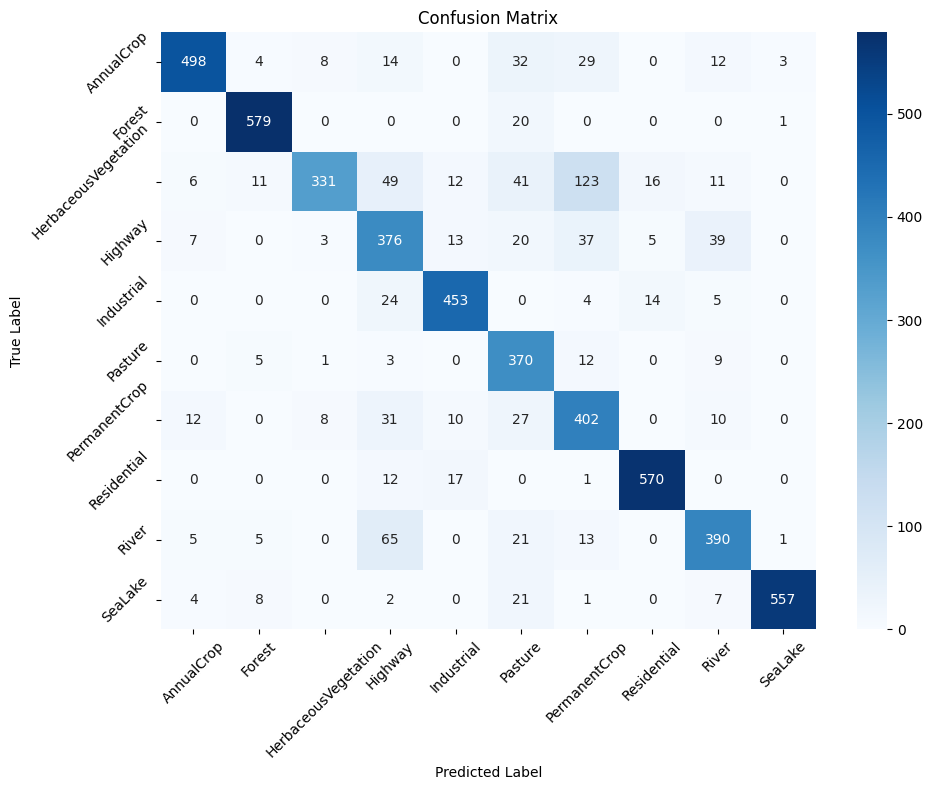

In [145]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Получение всех предсказаний и меток
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix building
# Построение confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualization
# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

Saving the trained model in two ways

Сохраним обученную модель двумя способами

In [125]:
# Saving only the model parameters (weights and offsets)
# Сохраняем только параметры модели (веса и смещения)
torch.save(model.state_dict(), 'GeoClassCNNModel.pth')

# Saving the entire model (not recommended, as it may be due to incompatibility of PyTorch versions)
# Сохраняем всю модель целиком (не рекомендуется, так как может быть связано с несовместимостью версий PyTorch)
torch.save(model, 'GeoClassCNNModel_full.pth')


#Using a trained model

#Применение обученной модели

Loading the model, or rather the scales

Загрузка модели, а точнее весов

In [135]:
model = EuroSATModel() # Creating the same model architecture | Создаём такую же архитектуру модели
model.load_state_dict(torch.load('GeoClassCNNModel.pth'))  # Loading the saved weights | Загружаем сохранённые веса
model.eval()  # Switching to evaluation mode | Переводим в режим оценки

EuroSATModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Uploading a fully saved model

Загрузка полностью сохраненной модели

In [138]:
model = torch.load('GeoClassCNNModel_full.pth', weights_only=False)  # The fully finished model is being loaded | Загружается полностью готовая модель
model.eval()  # Switching to evaluation mode | Переводим в режим оценки

EuroSATModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Checking on random images from the validation sample. We will load the libraries for random and numpy to limit the values of the image.

Проверка на случайных картинках из валидационной выборки. Подгрузим библиотеки для рандома и numpy для ограничения значений изображения.

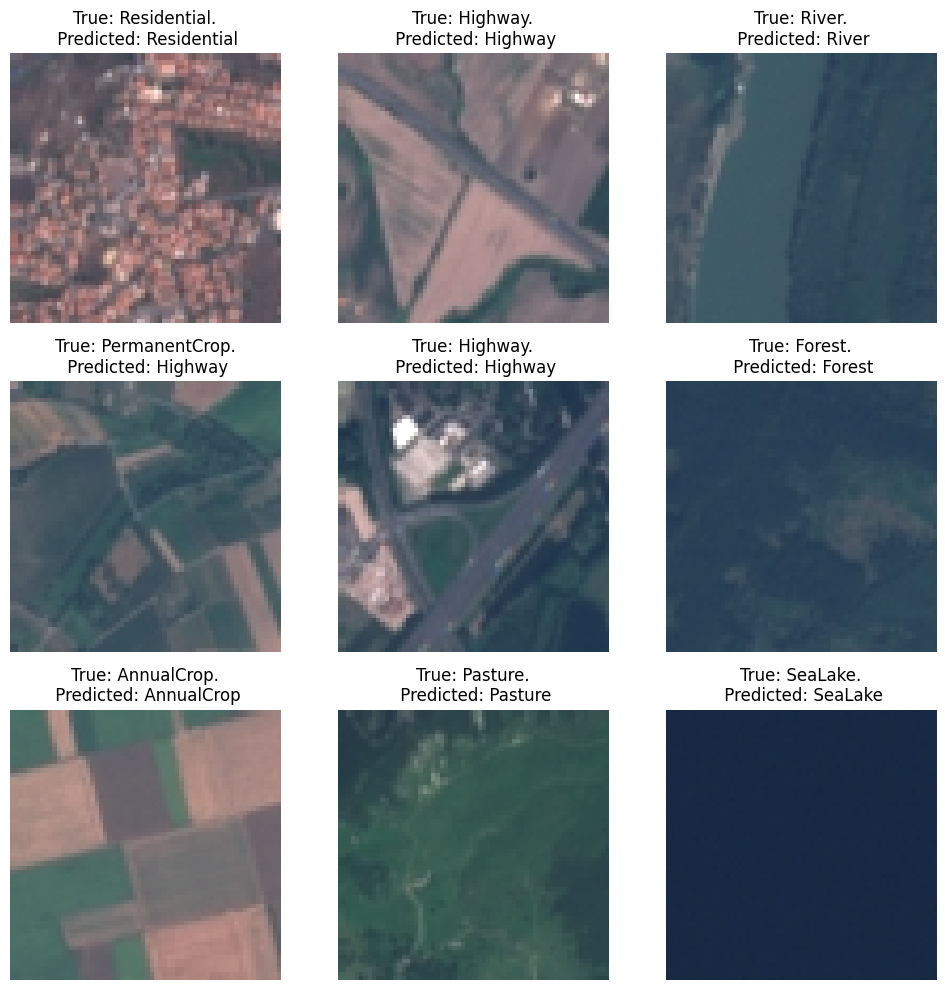

In [133]:
import random
import numpy as np
# Getting 9 random images from val_loader
# Получаем 9 случайных изображений из val_loader
images, labels = next(iter(val_loader))  # One batch is taken | Берем один батч
indexes = random.sample(range(len(images)), 9)  # Random 9 indexes | Случайные 9 индексов
sample_images = images[indexes]
sample_labels = labels[indexes]

# Runs through the entire model
# Прогоняем через модель
with torch.no_grad():
    outputs = model(sample_images)
    _, predicted = torch.max(outputs, 1)  # Indexes of predicted classes | Индексы предсказанных классов

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = sample_images[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"True: {class_names[sample_labels[i]]}.\n Predicted: {class_names[predicted[i]]}")

plt.tight_layout()
plt.show()

Checking on images not from the dataset

Проверка на картинках не из датасета

Predicted class: Residential


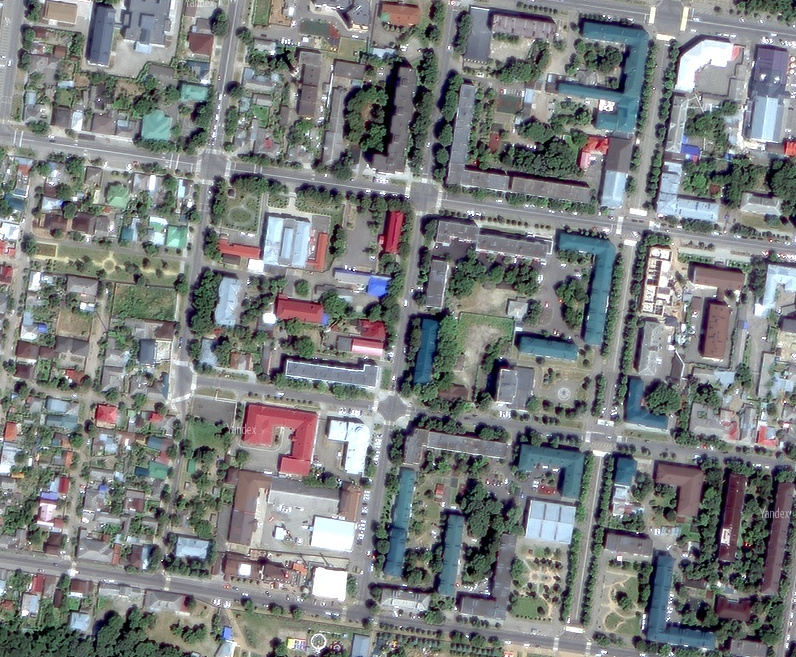

In [142]:
img_path = 'file_name.png' #or jpg or jpeg and more
img = Image.open(img_path).convert('RGB')
img_to_show = img
img = transform(img).unsqueeze(0)  # Adding batch dimension | Добавляем batch размерность

# Running it through the model | Прогоняем через модель
with torch.no_grad():
    output = model(img)

# We get a prediction (the class with the highest probability) | Получаем предсказание (класс с максимальной вероятностью)
_, predicted_class = torch.max(output, 1)
print(f"Predicted class: {class_names[predicted_class.item()]}")
img_to_show